In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from IPython.core.display import HTML
from scipy.stats import norm, poisson,expon,lognorm,skewnorm,exponnorm,skew,kstest
from math import pi
%matplotlib inline

# Capital loss prevention : statistical data analysis

In [21]:
# Import the cleaned loan data, didnt drop NaN's yet
loan_data = pd.read_csv('loan_data_eda.csv', index_col=False)#.dropna(axis=1)

In [22]:
numerical_data = loan_data.select_dtypes(include='number')
categorical_data = loan_data.select_dtypes(include='object')

The main concept I would like to focus on is the distribution of various numerical quantities. The amount of data and my naivety lead to my incorrect assumption that most quantities would be normally distributed. Because of this, I wanted to get a better idea of how different quantities are distributed and see if any patterns emerged. This process was done by creating a (non-exhaustive) list of distributions from SciPy and comparing their fits to the data. While visual inspection can be informative, it does not prove anything. Therefore the plots (which shall be shown later) comparing the histogram of each data feature to the kernel density estimate of the fit distributions is not truly representative of how well each model fits the data. 

To test this, the Kolmogorov-Smirnov test is employed and a comparison between the one-sample and two-sample tests is made.
The difference between one sample and two sample tests, in terms of SciPy functionality, is that the one sample test requires only the data samples and then the name and parameters of the distribution which to test against. The two sample test requires two samples; that is, two sets of samples. 

Because the number of samples in the data is so large, the choice is made to instead of performing the KS-test using all of the data, we shall replicate the test using samples. The reasons why this choice was made to ensure that the computation finishes on my personal machine. Of course, if we are comparing samples, then we should perform the test a number of times and create
a sampling distribution of ks-test values. 
The other reason is because I do not know before looking at the source code how the one-sided test is implemented and so I want to ensure that I give fair treatment between the two test types. 

In [23]:
# Function that takes all of the sample values of a feature X (DataFrame.column or NumPy array)
# and returns the equivalent number of samples(variates) from certain SciPy distributions
# specified by keyword argument, "distribution"
def fit_to_data(X, distribution='norm'):
    if distribution=='skewnorm':
        params = skewnorm.fit(X)
        variates = skewnorm.rvs(a=params[0], loc=params[1], scale=params[2],  size=len(X))
        
    elif distribution=='lognorm':
        params = lognorm.fit(X)
        variates = lognorm.rvs(s=params[0],loc=params[1],scale=params[2], size=len(X))

    elif distribution=='expon':
        params = expon.fit(X)
        variates = expon.rvs(loc=params[0],scale=params[1], size=len(X))

    elif distribution=='norm':
        params = norm.fit(X)
        variates = norm.rvs(loc=params[0], scale=params[0],size=len(X))

    elif distribution=='exponnorm':
        params = exponnorm.fit(X)
        variates = exponnorm.rvs(params[0],loc=params[1],scale=params[2], size=len(X))

    else:
        dlist = ['skewnorm','norm','expon','lognorm','exponnorm']
        print('Please specify one of the following distributions {},{},{},{},{}'.format(dlist))
        return None
    
    return params, variates


# Function that is used to contrast kernel density estimate distribution to histogram of actual
# values. 
def hist_density_plot(x, variates,xlabel=None, title=None):
    fig, ax1 = plt.subplots(1,1)
    ax1.hist(x, alpha=0.5,bins=50)
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel(xlabel)

    axtwin = ax1.twinx()
    sns.kdeplot(variates,ax=axtwin,color='r')
    axtwin.set_title(title)
    axtwin.set_ylabel('Density')
    plt.show()
    return None

def max_pairwise_correlations(loan_data):
    # Produce all correlations to the relations between features
    correlations_ = loan_data.corr()
    # Maximum correlations (excluding auto-correlation)
    correlations_df = correlations_.unstack().to_frame(name='data')
    # Remove the auto-correlations which are trivial / not useful values.
    correlations_no_auto = correlations_df[correlations_df['data']!=1]
    # To pick out the maximum pairwise correlations, 
    maxcvalues = correlations_no_auto[correlations_no_auto['data'] == correlations_no_auto.groupby(level=[0])['data'].transform(max)]
    return maxcvalues


def compare_distributions(sample1, sample2, dist='norm', size=10000):
    kstest(annual_inc_without_extreme_outliers,'exponnorm')

There a large reduction in the amount of data that can be used for the first part of the loan recommendation process. This is
because a large portion of the features are time dependent and therefore would contaminate the modeling process. Because of this, it seems appropriate to probe the statistics of the features that remain

In [ ]:
ndcr = numerical_data.corr()

f = plt.figure(figsize=(19, 15))
plt.matshow(ndcr, fignum=f.number)
# plt.xticks(range(loan_data.shape[1]), numerical_data.columns, fontsize=14, rotation=45)
plt.yticks(range(loan_data.shape[1]), numerical_data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=20)
plt.title('Correlation Matrix', fontsize=16);

Highly imbalanced data and highly correlated data require special care and considerations. First, let's make a coarse measurement as to how the data is balanced by look at how much of the data is equal to the mode.

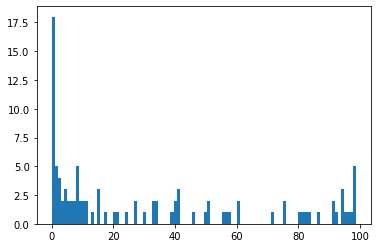

In [27]:
mode_percentages = [100*loan_data[col].value_counts().max()/len(loan_data) for col in loan_data.columns]

plt.hist(mode_percentages, bins=100)
_ = plt.show()

The quantities that are analyzed are:

    1. The annual income (without some very extreme outliers)
    2. Total payments made to date
    3. The percentage of credit being utilized
    4. Number of open accounts
    5. Debt to income ratio

Due to conversations regarding income inequality becoming more common, its fairly well known that the distribution of annual income does not follow a normal distribution. It is not clear if this will remain the case for the distribution of annual incomes of loan borrowers. This is the motivation for investigation.

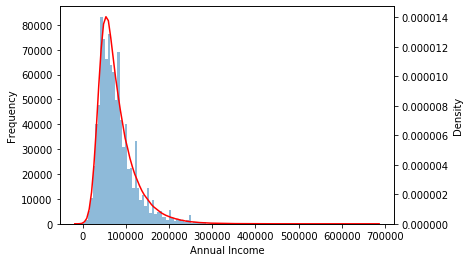

In [87]:
annual_inc_without_extreme_outliers = loan_data.annual_inc[loan_data.annual_inc < loan_data.annual_inc.quantile(0.99)]
annual_inc_enorm_fitparams, annual_inc_enorm_variates = fit_to_data(annual_inc_without_extreme_outliers, distribution='exponnorm')
hist_density_plot(annual_inc_without_extreme_outliers, annual_inc_enorm_variates, xlabel='Annual Income')

We have seen in the data exploration that the loan amounts are distributed unevenly due to the psychological power of pretty
round numbers. It might be expected, therefore, that the total payments would follow a similar distribution. It turns out however that they appear to be far more continuous; an interesting result

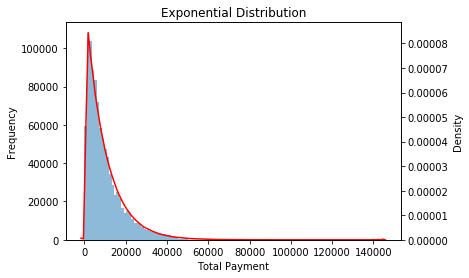

In [31]:
total_pymnt_exp_fitparams, total_pymnt_exp_variates = fit_to_data(loan_data.total_pymnt.dropna(), distribution='expon')
hist_density_plot(loan_data.total_pymnt, total_pymnt_exp_variates, xlabel='Total Payment',title='Exponential Distribution')

An alternative model for an exponentially distributed random variable Y is to take the log and model
it with either a skew-normal or normal distribution. This is likely a better choice because the skewness of the variates is ***not*** what would be expected from an exponential distribution, where it is a constant value independent of the commonly used exponential distribution parameter, $\lambda$. In order to apply the logarithm, however, the values equal to zero have to be removed to avoid transformed values of negative infinity; this is throwing away data from the sample distribution which is ill motivated. Therefore there is a trade off between accuracy and sample size when fitting models to data of this type.

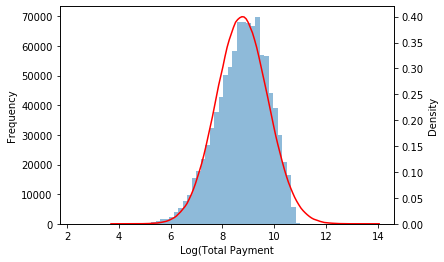

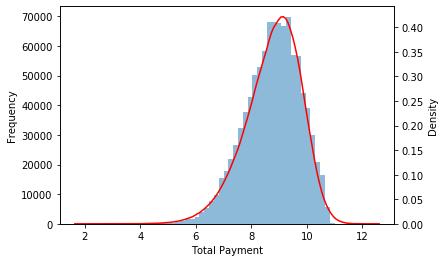

In [32]:
log_total_pymnt = loan_data.total_pymnt[loan_data.total_pymnt>0].dropna().apply(np.log)

total_pymnt_logn_fitparams, total_payment_logn_variates = fit_to_data(log_total_pymnt, distribution='lognorm')
hist_density_plot(log_total_pymnt, total_payment_logn_variates, xlabel='Log(Total Payment')

total_pymnt_skewn_fitparams, total_payment_skewn_variates = fit_to_data(log_total_pymnt, distribution='skewnorm')
hist_density_plot(log_total_pymnt, total_payment_skewn_variates, xlabel='Total Payment')

Another quantity previously reported was the utilization of credit; I believed that it followed a normal distribution
but it appears upon further analysis that is follows a log normal distribution; this shall be tested shortly.

In [90]:
all_util_skewnorm_fitparams, all_util_skewnorm_variates = fit_to_data(loan_data.all_util, distribution='skewnorm')

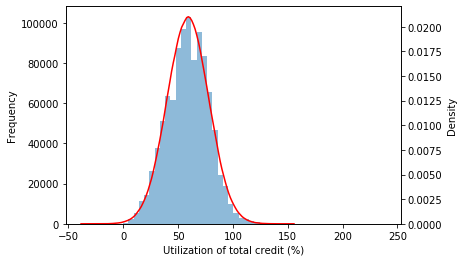

In [91]:
hist_density_plot(loan_data.all_util, all_util_skewnorm_variates, xlabel='Utilization of total credit (%)')

The number of open credit lines, a discrete valued quantity, nearly looks continuous when plotted as a histogram with bin
width greater than or equal to one. This presents an interesting test; given a discrete variable how well can it be modeled with a continuous distribution, taking only the integer part when sampling?

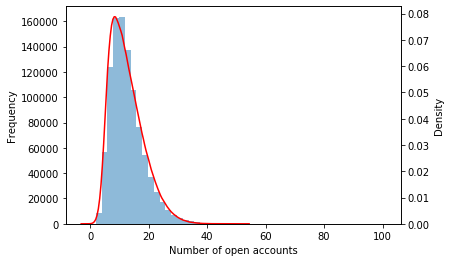

In [36]:
open_acc_skewnorm_fitparams, open_acc_skewnorm_variates = fit_to_data(loan_data.open_acc.dropna(), distribution='skewnorm')
hist_density_plot(loan_data.open_acc, open_acc_skewnorm_variates, xlabel='Number of open accounts')

The debt to income ratio is yet another quantity which is close to exponentially distributed has a skewness that says otherwise.

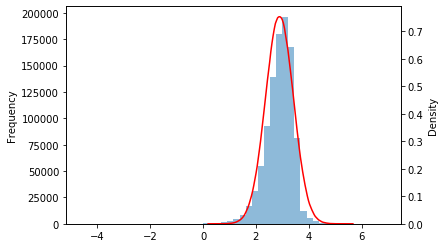

In [37]:
log_dti = loan_data.dti[loan_data.dti>0].dropna().apply(np.log)
dti_skn_fitparams, dti_skn_variates = fit_to_data(log_dti, distribution='skewnorm')
hist_density_plot(log_dti, dti_skn_variates)

Compare the sample distributions using the Kolmogorov-Sminov test using a custom function. The Kolmogorov-Smirnov test compares cumulative distribution functions of sample and reference distribution (one-sample) or compares the distributions of two-samples.  

Some distributions were shown earlier, but to claim that the distributions are accurate depictions of our sampling distributions, statistical testing is required. This could come in many different flavors but because I mainly want to compare sample to predicted distributions I will employ the Kolmogorov-Smirnov test to the sets of variates created above.

In order for the testing to run in a reasonable time, I shall use a smaller sample size than what I used to fit the distributions above. 

In each of the following, the null hypothesis is that the loan data in question is distributed in the way we claim. The
alternative hypothesis is that it is not distributed in this way. More precisely, because I am using the Kolmogorov-Smirnov
test, the hypothesis testing involves the CDF's not the PDF's. Therefore if the p-value of the hypothesis tests are less than
0.05 then the null hypothesis is rejected with 95% confidence. In other words, the CDFs are not equal to our claim.

In [76]:
# Claim was exponnormal
annual_inc_kstest = kstest(annual_inc_without_extreme_outliers.sample(10000), 'exponnorm', args=annual_inc_enorm_fitparams)

In [77]:
# Claim was exponential distribution
total_pymnt_kstest = kstest(loan_data.total_pymnt.sample(10000), 'expon', args=total_pymnt_exp_fitparams)

In [78]:
# Claim was log-normal
log_total_pymnt_kstest_lognorm = kstest(log_total_pymnt.sample(10000),'lognorm', args=total_pymnt_logn_fitparams)

In [79]:
# Claim was skew-normal
log_total_pymnt_kstest_skewnorm = kstest(log_total_pymnt.sample(10000),'skewnorm', args=total_pymnt_skewn_fitparams)

In [80]:
# Claim was log-normal
all_util_kstest = kstest(loan_data.all_util.sample(10000),'lognorm', args=all_util_lognorm_fitparams)

In [81]:
# Claim was skew-normal
open_acc_kstest = kstest(loan_data.open_acc.sample(10000),'skewnorm', args=open_acc_skewnorm_fitparams)

In [82]:
# Claim was exponnormal
log_dti_kstest = kstest(log_dti.sample(10000),'skewnorm', args=dti_skn_fitparams)

In [92]:
print('The p-value for the annual income being a exponential-normal distribution is {}'.format(annual_inc_kstest.pvalue))
print('The p-value for the log of total payment data being a log-normal distribution is {}'.format(log_total_pymnt_kstest_lognorm.pvalue))
print('The p-value for the log of total payment data being a skew-normal distribution is {}'.format(log_total_pymnt_kstest_skewnorm.pvalue))
print('The p-value for the utilized credit percentage being a skew-normal distribution is {}'.format(all_util_kstest.pvalue))
print('The p-value for the annual income being a skew-normal distribution is {}'.format(open_acc_kstest.pvalue))
print('The p-value for the log of the debt to income ratio being a skew-normal distribution is  {}'.format(log_dti_kstest.pvalue))

The p-value for the annual income being a exponential-normal distribution is 1.1840154413373579e-05
The p-value for the log of total payment data being a log-normal distribution is 9.305272930319027e-09
The p-value for the log of total payment data being a skew-normal distribution is 0.012102373785575339
The p-value for the utilized credit percentage being a skew-normal distribution is 0.0
The p-value for the annual income being a skew-normal distribution is 3.942810987345747e-29
The p-value for the log of the debt to income ratio being a skew-normal distribution is  3.13097821399214e-23


The only claim that has any merit whatsoever is the logarithm of the total payments being a skew normal distribution. It seems
that the kernel density estimate plots are more misleading than I thought.

There are a number of pairs of features with pearson correlation scores greater than 0.999 for a specific and relatively obvious reason. Specifically, some features are essentially identical; an example being: the funded amount of a loan and funded aamount of a loan from investors. If investors represent the overwhelming majority of loan funding then these features are nearly identical which seems to be the case upon inspection.The best course of action seems to be to leave the features untouched and to simply include considerations for these properties such as regularization and balanced class weighting. 

In [112]:
max_pairwise_correlations(loan_data).sort_values(by='data',ascending=False)[:20:2]

,,data
fico_range_high,fico_range_low,1.000000
funded_amnt,loan_amnt,0.999999
out_prncp,out_prncp_inv,0.999999
total_pymnt_inv,total_pymnt,0.999996
funded_amnt_inv,funded_amnt,0.999995
open_acc,num_sats,0.999516
num_actv_rev_tl,num_rev_tl_bal_gt_0,0.999125
recoveries,collection_recovery_fee,0.991012
tot_cur_bal,tot_hi_cred_lim,0.972898
total_bal_il,total_il_high_credit_limit,0.951029


Because the main targets are the loan status and the recovery amounts, it is prudent to investigate the correlations
with these variables. Because the loan status is a categorical variable, it would have to be encoded in order for this to be
well defined. Pandas has one-hot encoding via a function "get_dummies"

In [121]:
test_corr_dummies = pd.get_dummies(loan_data.loan_status)

Because the problem is transformed into a binary classification problem, do not need other categories of loan status
other than "Charged Off" and "Fully Paid".

In [124]:
test_corr = pd.concat((test_corr_dummies.loc[:, ['Charged Off', 'Fully Paid']], 
                       loan_data.select_dtypes(include='number')), axis=1).corr()

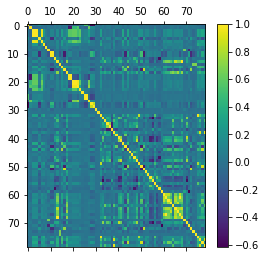

In [125]:
plt.matshow(test_corr, cmap='viridis', aspect='auto')
_ = plt.colorbar()
_ = plt.show()

Highlighting extreme (nearly correlated) values shows that there are some features that likely should be dropped

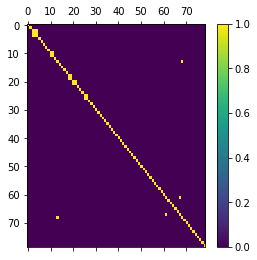

In [131]:
plt.matshow(test_corr[test_corr>0.99].fillna(value=0), cmap='viridis', aspect='auto')
_ = plt.colorbar()
_ = plt.show()

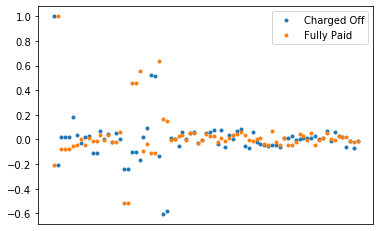

In [149]:
test_corr.iloc[:, :2].plot(marker='.', linestyle='none')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

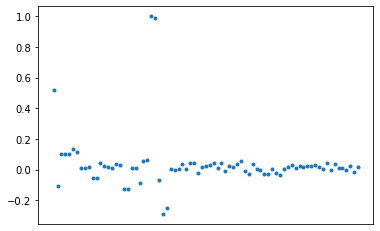

In [153]:
test_corr.loc[:, 'recoveries'].plot(marker='.', linestyle='none')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

In [155]:
test_corr.loc[:, 'recoveries'].sort_values(ascending=False)

recoveries                 1.000000
collection_recovery_fee    0.991012
Charged Off                0.522208
int_rate                   0.135668
installment                0.115674
                             ...   
Fully Paid                -0.108393
out_prncp_inv             -0.126051
out_prncp                 -0.126065
last_fico_range_low       -0.248924
last_fico_range_high      -0.288690
Name: recoveries, Length: 79, dtype: float64

So it is likely prudent to at least remove the collection recovery fee feature from the modeling of the recoverable capital modeling